# Importing Packages

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import h5py

# Functions for Constructing Matrices

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# Data Storing Scripts

In [3]:
def remove_dataset(h5_file, dataset_name, **kwargs):
    """
    Remove a specific dataset from an HDF5 file.

    Args:
        h5_file (str): Path to the HDF5 file.
        dataset_name (str): Name of the dataset to remove.
    """
    with h5py.File(h5_file, 'a') as f:  # Open in append mode to modify the file
        if dataset_name in f:
            del f[dataset_name]  # Remove the dataset
            print(f"Dataset '{dataset_name}' has been removed.")
        else:
            print(f"Dataset '{dataset_name}' not found in the file.")


In [4]:
def append_to_dataset(h5_file, dataset_name, new_data, **kwargs):
    """
    Append new data to a dataset in an HDF5 file. If the dataset does not exist, create it.

    Args:
        h5_file (str): Path to the HDF5 file.
        dataset_name (str): Name of the dataset to append to.
        new_data (numpy array): New data to append.
    """
    with h5py.File(h5_file, 'a') as f:  # Open in append mode
        if dataset_name in f:
            dataset = f[dataset_name]
            dataset.resize((dataset.shape[0] + new_data.shape[0]), axis=0)
            dataset[-new_data.shape[0]:] = new_data  # Append new data at the end
        else:
            # If the dataset doesn't exist, create it with the initial shape
            maxshape = (None,) + new_data.shape[1:]  # None means unlimited in first dimension
            f.create_dataset(dataset_name, data=new_data, maxshape=maxshape)
        print(f"Appended data to dataset '{dataset_name}' in '{h5_file}'.")



In [5]:
def read_dataset(h5_file, dataset_name, **kwargs):
    """
    Read and return data from a dataset in an HDF5 file.

    Args:
        h5_file (str): Path to the HDF5 file.
        dataset_name (str): Name of the dataset to read from.
    
    Returns:
        numpy array: The data read from the dataset.
    """
    with h5py.File(h5_file, 'r') as f:  # Open in read mode
        if dataset_name in f:
            data = f[dataset_name][:]
            return data
        else:
            print(f"Dataset '{dataset_name}' not found in '{h5_file}'.")
            return None

# Definitions

In [6]:
params = {}
params['L'], params['N'], params['nmax'] = 64, 64, 4
params['L1'], params['L2'], params['L3'] = 30, 34, 64 
params['t'], params['U1'], params['U2'], params['U3'] = 1.0, 0.5, 10.0, 0.5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny | SymmetryTypes.CPX, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [7]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

# Definig Operators
bdag = np.diag(np.sqrt(np.arange(1, params['nmax'] + 1)), k=-1) # b+
b = bdag.T # b
n = np.diag(np.arange(0, params['nmax'] + 1), k=0) # particle number 
parity = np.diag([(-1.)**n for n in range(params['nmax']+1)]) # Parity no.

for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['nmax'] + 1)] 
    ops = {
        "": np.identity(params['nmax'] + 1), # identity
        "C": bdag, # b+
        "D": b,  # b
        "N": n, # particle number
        "P": parity, # Parity no.
    }
    site_basis.append(basis)
    site_ops.append(ops)

# Setting Up Hamiltonian

In [8]:
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()


for i in range(params['L']-1):
    b.add_term("CD", [i, i+1], -params['t'])
    b.add_term("CD", [i+1, i], -params['t'])

# Region 1 
for i in range(0, params['L2'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U1'] / 2)
    b.add_term("CD", [i, i], - params['U1'] / 2)

# Region 2
for i in range(params['L1'], params['L2'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U2'] / 2)
    b.add_term("CD", [i, i], - params['U2'] / 2)

# Region 3
for i in range(params['L2'], params['L3'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U3'] / 2)
    b.add_term("CD", [i, i], - params['U3'] / 2)

In [9]:
# [Part C] Perform DMRG

start_time = time.time()
#########################################

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * params['L'])
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")



Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.654 | E =    -142.4657459909 | DW = 4.69478e-10

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      3.406 | E =    -143.1287382307 | DE = -6.63e-01 | DW = 5.61106e-08

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      6.896 | E =    -143.3273817097 | DE = -1.99e-01 | DW = 2.84203e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      9.190 | E =    -143.4299862786 | DE = -1.03e-01 | DW = 1.47132e-07

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     12.034 | E =    -143.4868379331 | DE = -5.69e-02 | DW = 2.60065e-07

Sweep =    5 | Direction = backward 

## <font color='blue'>Current Measurement</font>

### <font color='black'>Constructing MPO for $(-1)^{\hat{N}_{R_{1}}}$ where $\hat{N}_{R_{1}} = \sum_{i \in R_{1}} n_{i}$</font>

In [10]:
b_n = driver.expr_builder()
Parity_L1 = "P" * params['L1'] 
lst_index_L1 = list(range(params['L1']))
# b_n.add_term(Parity_L1, lst_index_L1, 1)
b_n.add_term('PPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], 1)
N1_op = driver.get_mpo(b_n.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite, iprint = 1)


Build MPO | Nsites =    64 | Nterms =          1 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     1 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     2 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     3 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     4 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     5 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     6 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     7 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     8 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc

### <font color='black'>Applying $\ket{\psi^{\prime}} = (-1)^{\hat{N}_{R_{1}}}\ket{\psi}$</font>

In [11]:
# bra = driver.get_random_mps(tag="BRA_N1_op", bond_dim=1000, nroots=1, occs=[1] * params['L'])
# bra = driver.get_random_mps(tag="BRA_N1_op", bond_dim=1000, nroots=1, center=mps.center)
bra = driver.copy_mps(mps,"NewKet")
driver.multiply(bra, N1_op, mps, n_sweeps=10, bond_dims=[1000], thrds=[1E-10] * 10, iprint=1)


Sweep =    0 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     21.813 | F = (0.1793196823,0.0000000000) | DW = 3.24512e-18

Sweep =    1 | Direction = backward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     44.757 | F = (1.0000000000,0.0000000000) | DF = (8.21e-01,0.00e+00) | DW = 4.80119e-18

Sweep =    2 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     67.852 | F = (1.0000000000,0.0000000000) | DF = (1.22e-15,0.00e+00) | DW = 1.41005e-18

Sweep =    3 | Direction = backward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     90.840 | F = (1.0000000000,0.0000000000) | DF = (2.22e-16,0.00e+00) | DW = 3.40780e-18

Sweep =    4 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =    114.134 | F = (1.0000000000,0.0000000000) | DF = (2.22e-16,0.00e+00) | DW = 9.83010e-19



(0.9999999999999983+0j)

#### <font color='blue'>Single-particle boson correlations</font>

##### Calculate

In [12]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(bra, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = (63.999999999999666-3.064411430646754e-16j)
Elapsed time: 31.07212495803833 seconds


##### Site occupations

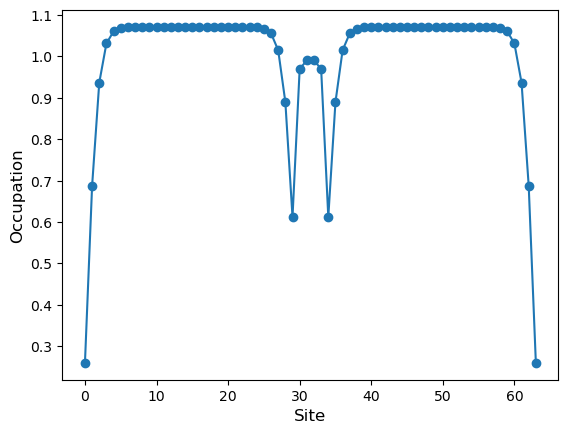

In [13]:
navg = np.real(navg)
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

##### Correlation matrix

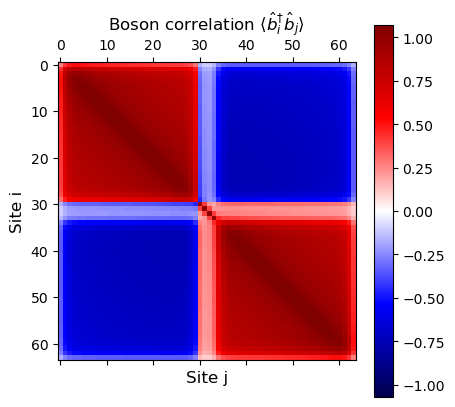

In [14]:
bosoncorr_mat = np.real(bosoncorr_mat)
plt.matshow(bosoncorr_mat, cmap='seismic', vmin=-np.abs(bosoncorr_mat).max(), vmax=np.abs(bosoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

##### Correlation vs distance

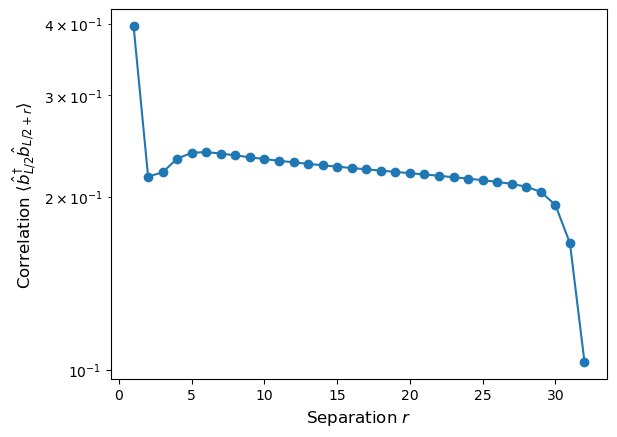

In [15]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### <font color='black'>Time Evolution of $\ket{\psi^{\prime}}$:: $\ket{\psi(t)} = e^{-i\cdot t \cdot H_{AJJ}}\ket{\psi^{\prime}}$</font>

In [57]:
params['target_t'] = 0.6

In [58]:
bra2 = driver.copy_mps(bra, tag = "PsiPrime")
bra2 = driver.td_dmrg(mpo = mpo, ket = bra2, delta_t=0.1 * 1j, target_t = params['target_t'] * 1j, final_mps_tag="mps3", bond_dims = [1000], hermitian=True, iprint = 1)

Time Evolution  DELTA T = RE      0.00000000 + IM      0.10000000
Time Evolution TARGET T = RE      0.00000000 + IM      0.60000000
Time Evolution   NSTEPS =          6
Sweep =    0 ( 0/ 2) | Direction = backward | Beta = (0.00000,0.10000) | Bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     74.178 | E = (-141.7167182254,-0.0000000000) | Norm^2 =       0.9999997751 | DW = 1.41103e-09
Sweep =    0 ( 1/ 2) | Direction =  forward | Beta = (0.00000,0.10000) | Bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =    181.049 | E = (-141.7167183934,0.0000000000) | Norm^2 =       0.9999997547 | DW = 1.40669e-09
T =    0.00000 +    0.10000i <E> = -141.716718393393108 +    0.00000i <Norm^2> =    0.999999754708628 +    0.00000i
Sweep =    0 ( 0/ 2) | Direction = backward | Beta = (0.00000,0.10000) | Bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =    111.977 | E = (-141.7167233654,-0.0000000000) | Norm^2 =       0.9999996039 | DW = 1.27287e-07
Sweep =    0 ( 1/ 2) | Direction

#### <font color='blue'>Single-particle boson correlations</font>

##### Calculate

In [59]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(bra2, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = (63.99249333069361-2.661364362283405e-16j)
Elapsed time: 81.3054711818695 seconds


##### Site occupations

[0.25959307 0.68734829 0.93655395 1.0312512  1.06036415 1.06836138
 1.07043476 1.07096827 1.07111398 1.07116351 1.07119333 1.07122891
 1.07125257 1.0712792  1.07130472 1.07132249 1.07133842 1.07132523
 1.07133697 1.07133957 1.07128239 1.07124072 1.07119204 1.07091544
 1.06985569 1.06682907 1.06080182 1.06045532 0.98626294 0.69213977
 0.77182231 0.95350019 0.98972744 0.97224961 0.62128284 0.89124034
 1.01427132 1.05535973 1.06718011 1.07012682 1.07091811 1.07114711
 1.07097038 1.0707129  1.07080783 1.07065661 1.07104755 1.07167233
 1.07169068 1.07144914 1.0713897  1.0715646  1.07234788 1.07145063
 1.07107519 1.0708968  1.07071266 1.07010888 1.06762986 1.06133267
 1.03021227 0.93764265 0.68757135 0.25967569]


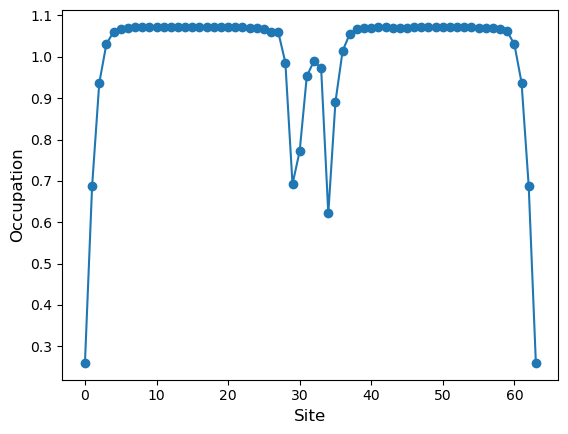

In [60]:
navg = np.real(navg)
print(navg)
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

##### Correlation matrix

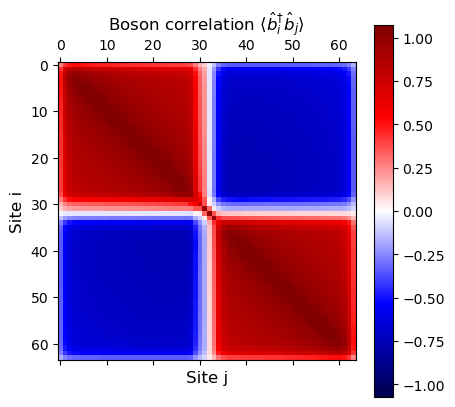

In [61]:
bosoncorr_mat = np.real(bosoncorr_mat)
plt.matshow(bosoncorr_mat, cmap='seismic', vmin=-np.abs(bosoncorr_mat).max(), vmax=np.abs(bosoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

##### Correlation vs distance

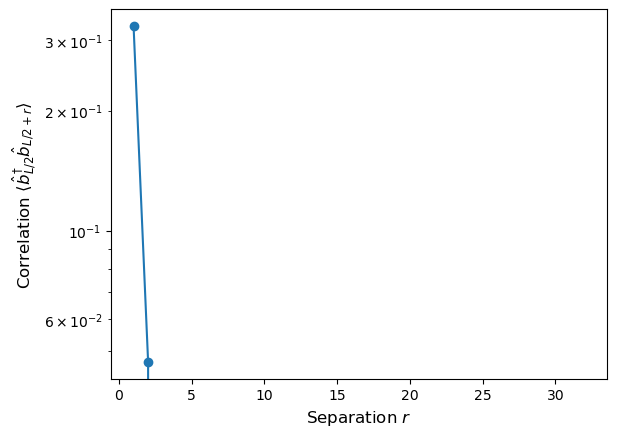

In [62]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### <font color='black'>Expectation Value of $N_{R_{1}} - N_{R_{2}}$ w.r.t $\psi(t)$</font>

#### <font color='black'>Constructing MPO for $\hat{N}_{R_{1}}$ and $\hat{N}_{R_{2}}$ where $\hat{N}_{R_{j}} = \sum_{i \in R_{j}} n_{i}$ where $j \in {1,2}$</font>

In [63]:
b_n1 = driver.expr_builder()
lst_index_L1 = list(range(params['L1']))
b_n1.add_term("N", lst_index_L1, 1)
N1_op2 = driver.get_mpo(b_n1.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite, iprint = 1)


Build MPO | Nsites =    64 | Nterms =         30 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        2 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     1 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     2 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     3 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     4 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     5 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     6 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     7 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc = 0.000 T = 0.000
 Site =     8 /    64 .. Mmpo =     2 DW = 0.00e+00 NNZ =        3 SPT = 0.2500 Tmvc

In [64]:
b_n2 = driver.expr_builder()
lst_index_L2 = list(range(params['L2'], params['L3']))
b_n2.add_term("N", lst_index_L2, 1)
N2_op = driver.get_mpo(b_n2.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite, iprint = 1)


Build MPO | Nsites =    64 | Nterms =         30 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     1 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     2 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     3 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     4 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     5 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     6 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     7 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     8 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc

#### <font color='black'>Expectation Value</font>

In [65]:
# n1n2diff_exp = []

In [66]:
impo = driver.get_identity_mpo()

n1_op_exp = driver.expectation(bra2, N1_op2, bra2) / driver.expectation(bra2, impo, bra2)

n2_op_exp = driver.expectation(bra2, N2_op, bra2) / driver.expectation(bra2, impo, bra2)

In [67]:
# n1n2diff_exp.append(n1_op_exp - n2_op_exp)

#### <font color='black'>Data of $\bra{\psi(t)} N_{R_{1}} - N_{R_{2}}\ket{\psi(t)}$</font>

In [68]:
# remove_dataset('my_data.h5', '1_n1n2diff_exp')

In [69]:
with h5py.File('my_data.h5', 'a') as f:
    dataset_name = f'{params['target_t']}_n1n2diff_exp'  # Name the dataset uniquely to avoid conflicts
    if dataset_name in f:
        print(f"Dataset '{dataset_name}' already exists.")
    else:
        f.create_dataset(dataset_name, data=[n1_op_exp - n2_op_exp])
        print(f"Dataset '{dataset_name}' created.")

print("List appended to HDF5 file.")


Dataset '0.6_n1n2diff_exp' created.
List appended to HDF5 file.


In [70]:
with h5py.File('my_data.h5', 'r') as f:
    # Print all dataset names in the file
    for name in f:
        print(f"Dataset: {name}")
        print("Data:", f[name][:])


Dataset: 0.0_n1n2diff_exp
Data: [2.47892373e-08-9.01071469e-17j]
Dataset: 0.1_n1n2diff_exp
Data: [0.00778834-1.16583897e-16j]
Dataset: 0.2_n1n2diff_exp
Data: [0.03399258+8.59352612e-15j]
Dataset: 0.3_n1n2diff_exp
Data: [0.07823029+4.43084169e-15j]
Dataset: 0.6_n1n2diff_exp
Data: [0.21693003-5.55399751e-15j]
Dataset: 0.7_n1n2diff_exp
Data: [0.22708731-3.52536893e-15j]
Dataset: 0.8_n1n2diff_exp
Data: [0.20955084-7.0381515e-15j]
Dataset: 0.9_n1n2diff_exp
Data: [0.19428449-9.03723259e-15j]
Dataset: 1.0_n1n2diff_exp
Data: [0.18313456-5.54332226e-15j]
Dataset: 1.1_n1n2diff_exp
Data: [0.18767816-4.36681792e-15j]
Dataset: 1.2_n1n2diff_exp
Data: [0.20667519-2.71381159e-14j]


In [197]:
print(n1n2diff_exp)

[(0.18023073507043819-2.485820080869904e-14j), (0.007788336327493539-1.1658389684688993e-16j), (0.03399257827400248+8.593526120361154e-15j), (0.07823029347923338+4.430841688015311e-15j), (0.19428448620615058-9.037232594348457e-15j), (0.1876781590296659-4.366817919674194e-15j), (2.4789237329514435e-08-9.010714687310564e-17j), (2.4789237329514435e-08-9.010714687310564e-17j), (0.18313455812621626-5.543322257929157e-15j)]


## <font color='blue'>Entanglement</font>

In [ ]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,params['L']), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

### Calculate

In [ ]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Site occupations

In [ ]:
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

In [ ]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

In [ ]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [ ]:
start_time = time.time()

ndist = np.array(driver.get_npdm(mps, npdm_expr=proj_keys, fermionic_ops='')).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(params['L'])]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Site-averaged number distribution

In [ ]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuation

In [ ]:
nsqavg = np.array([np.dot(np.arange(params['nmax']+1)**2, ndist[i]) for i in range(params['L'])])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(params['L']), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

### Calculate

In [ ]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='CDCD', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Correlation matrix

In [ ]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

In [ ]:
plt.plot(np.arange(1,params['L']//2+1), -densitycorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()